  # Primary statistical testing workflow

This is the primary statistical testing workflow we are recommending.  This should work for the majority of cases in small molecule property prediction.


  ### Installation

  <pre>pip install pandas pingouin seaborn matplotlib scikit-learn </pre>

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import sys
sys.path.append('..')

from model_comparison import calc_regression_metrics, make_boxplots_nonparametric, make_scatterplot, make_sign_plots_nonparametric, make_critical_difference_diagrams

  ### 1. Read in data

In [5]:
df_input = pd.read_csv("../Sol_results.csv")
df_input = df_input[df_input['dset'] == 'test']

methods = list(df_input.columns[-3:])
df_melted = pd.melt(df_input, id_vars=['fold', 'group', 'SMILES', 'Sol'],
                    value_vars=methods, var_name='method', value_name='Sol_pred')

df_melted.rename(columns={'fold': 'cv_cycle', 'group': 'split', 'Sol': 'Sol'}, inplace=True)
df_melted['Name'] = 'Mol' + (df_melted.index + 1).astype(str)

df_input = df_melted.copy()

# Solubilty was in log micromolar, adjust to log molar
df_input["Sol"] = df_input["Sol"] - 6
df_input["Sol_pred"] = df_input["Sol_pred"] - 6

  ### 2. Calculate Regression Metrics

In [6]:
classification_cutoff = -4
df_metrics = calc_regression_metrics(df_input, "cv_cycle", "Sol", "Sol_pred", classification_cutoff)
metric_ls = df_metrics.columns[3:]

Select the data generated from scaffold splits

In [7]:
df_scaffold_split = df_metrics.query("split == 'scaffold'")

  ### 3.  Current Suboptimal Practice in Many Papers (Don't do this!)

  Many papers that compare ML models simply show a table with the average of each metric over multiple folds of cross validation. The largest value is shown in bold and considered to be the "winner". **This not the correct way to represent a comparison!** Remember, we're comparing distributions, which should never be compared by simply using the mean.

In [8]:
row_list = []
for k, v in df_scaffold_split.groupby("method"):
    row_list.append([k, v.mae.mean(), v.mse.mean(), v.r2.mean(), v.rho.mean(), v.recall.mean(), v.prec.mean()])
terrible_df = pd.DataFrame(row_list, columns=["Method", "MAE", "MSE", "R2", "Rho", "Recall", "Precision"])

terrible_df.style.hide().format(precision=3).highlight_max(subset=["R2", "Rho", "Recall", "Precision"],
                                                                  props='font-weight: bold', axis=0) 

Method,MAE,MSE,R2,Rho,Recall,Precision
chemprop_mt,0.384,0.300,0.401,0.598,0.582,0.856
chemprop_st,0.369,0.299,0.404,0.598,0.661,0.840
lgbm_morgan,0.440,0.374,0.254,0.518,0.491,0.849


  ### 3. Comparing Distributions Across Cross-Validation Folds


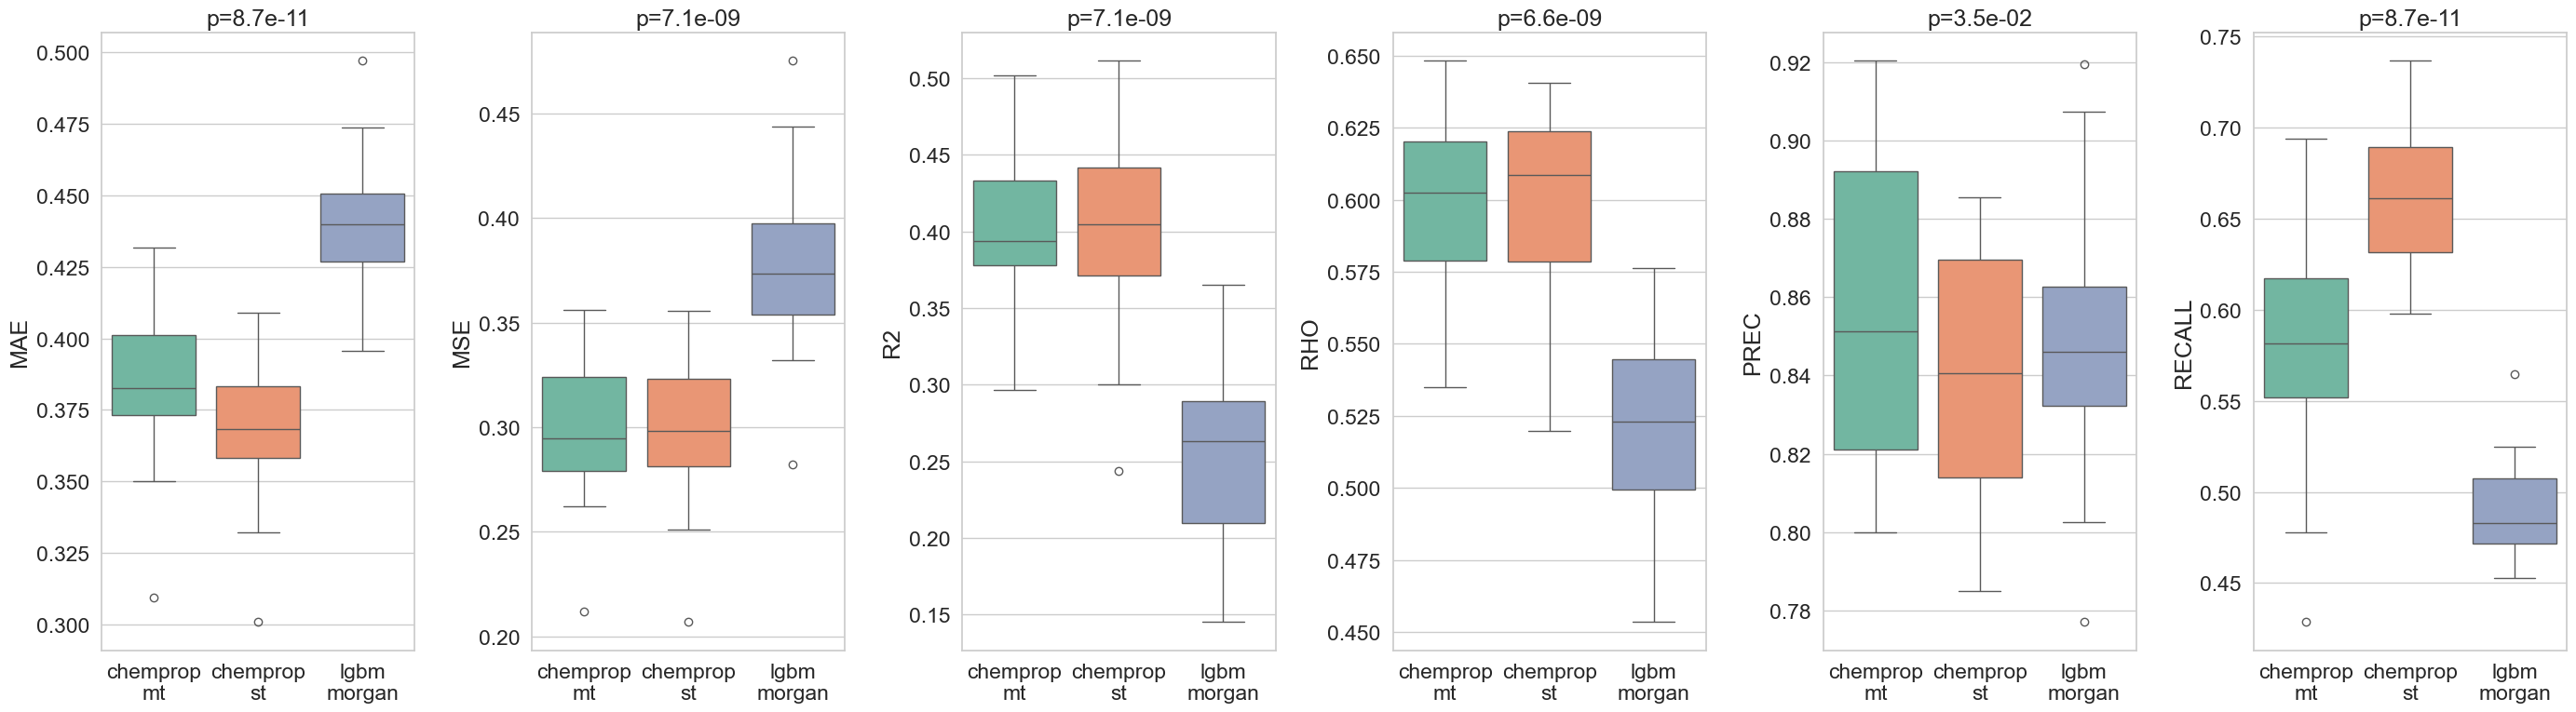

In [15]:
make_boxplots_nonparametric(df_scaffold_split, metric_ls)

  ### 4. Perform a Post-Hoc Analysis to Examine Differences Between Methods

  Friedman's test tells us **if** there is difference between three or more distributions, but it doesn't tell us **where** the difference is.  We can use post-hoc tests to look at inidividual differences.  Note that the p-value for the individual comparisons is corrected to account for multiple compararions. In this case we'll use the [Holm Bonferroni Method](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method#:~:text=In%20statistics%2C%20the%20Holm%E2%80%93Bonferroni,powerful%20than%20the%20Bonferroni%20correction). 

#### 4.1 Sign Plots
Fortunately, scikit-posthocs provides a couple of useful plots for visualizing the results of post-hoc tests.  The first is the sign plot.  This shows the matrices above color coded by statistical significance.  Each cell in the plot shows the corrected p-value for one pairwise comparison.  

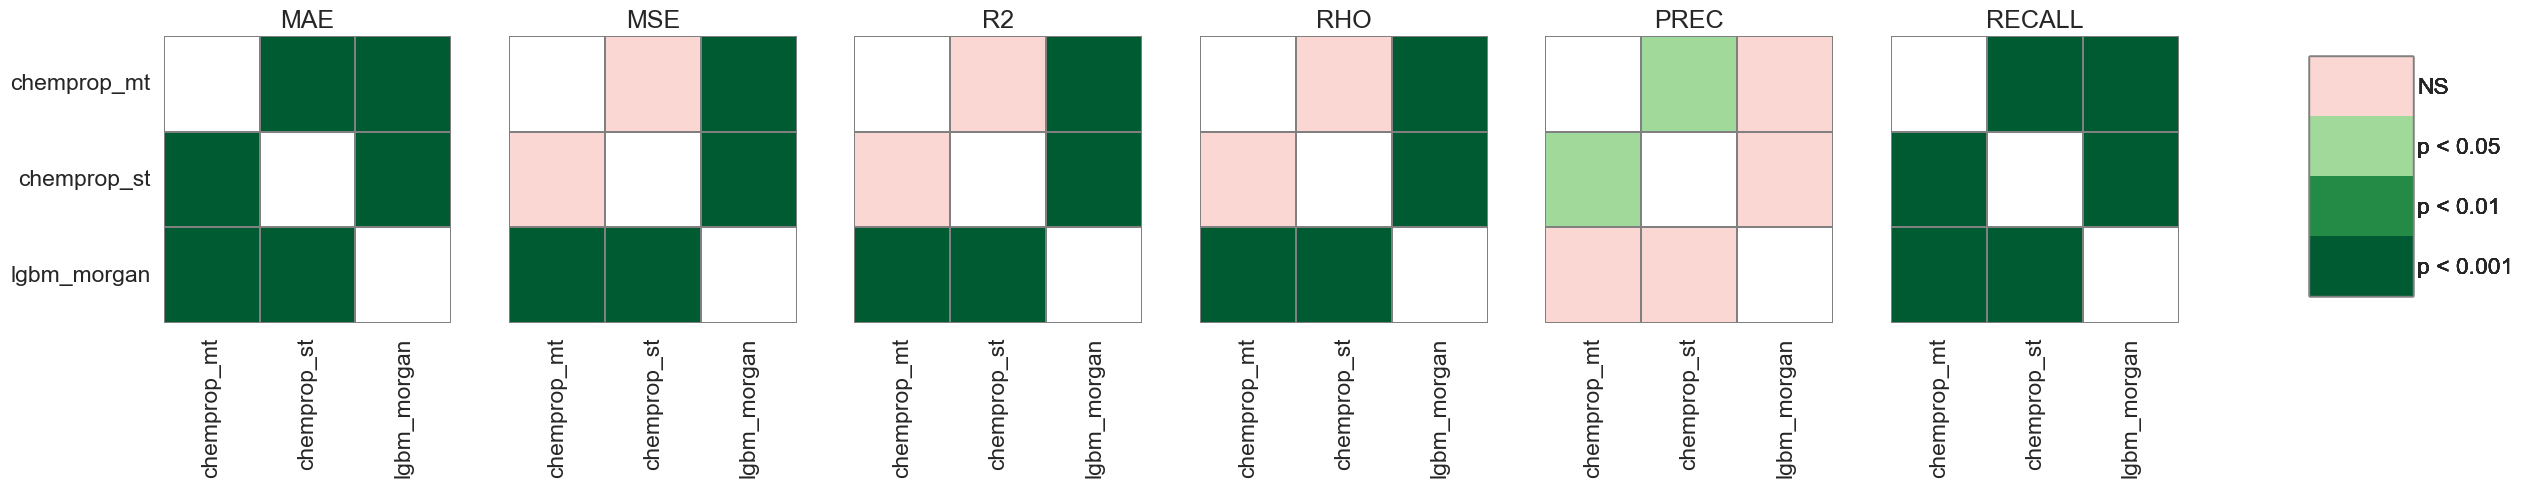

In [17]:
make_sign_plots_nonparametric(df_scaffold_split, metric_ls)

#### 4.2 Critical Difference Diagrams

Another interesting visualization provoided by scikit-posthocs is the [critical difference diagram](https://mirkobunse.github.io/CriticalDifferenceDiagrams.jl/dev/#Reading-a-CD-diagram) (CDD).  In this plot, the methods are ordered by their average ranks.  If two methods are connected by a horizontal line, there is **not** a statistically significant difference between the methods.  One advantage of the CDD over the sign plot is that the CDD aslo shows the ranks of the methods.

c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_py311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_py311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_py311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
c:\Users\Jash4\AppData\Local\anaconda3\envs\chemprop_py311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'S

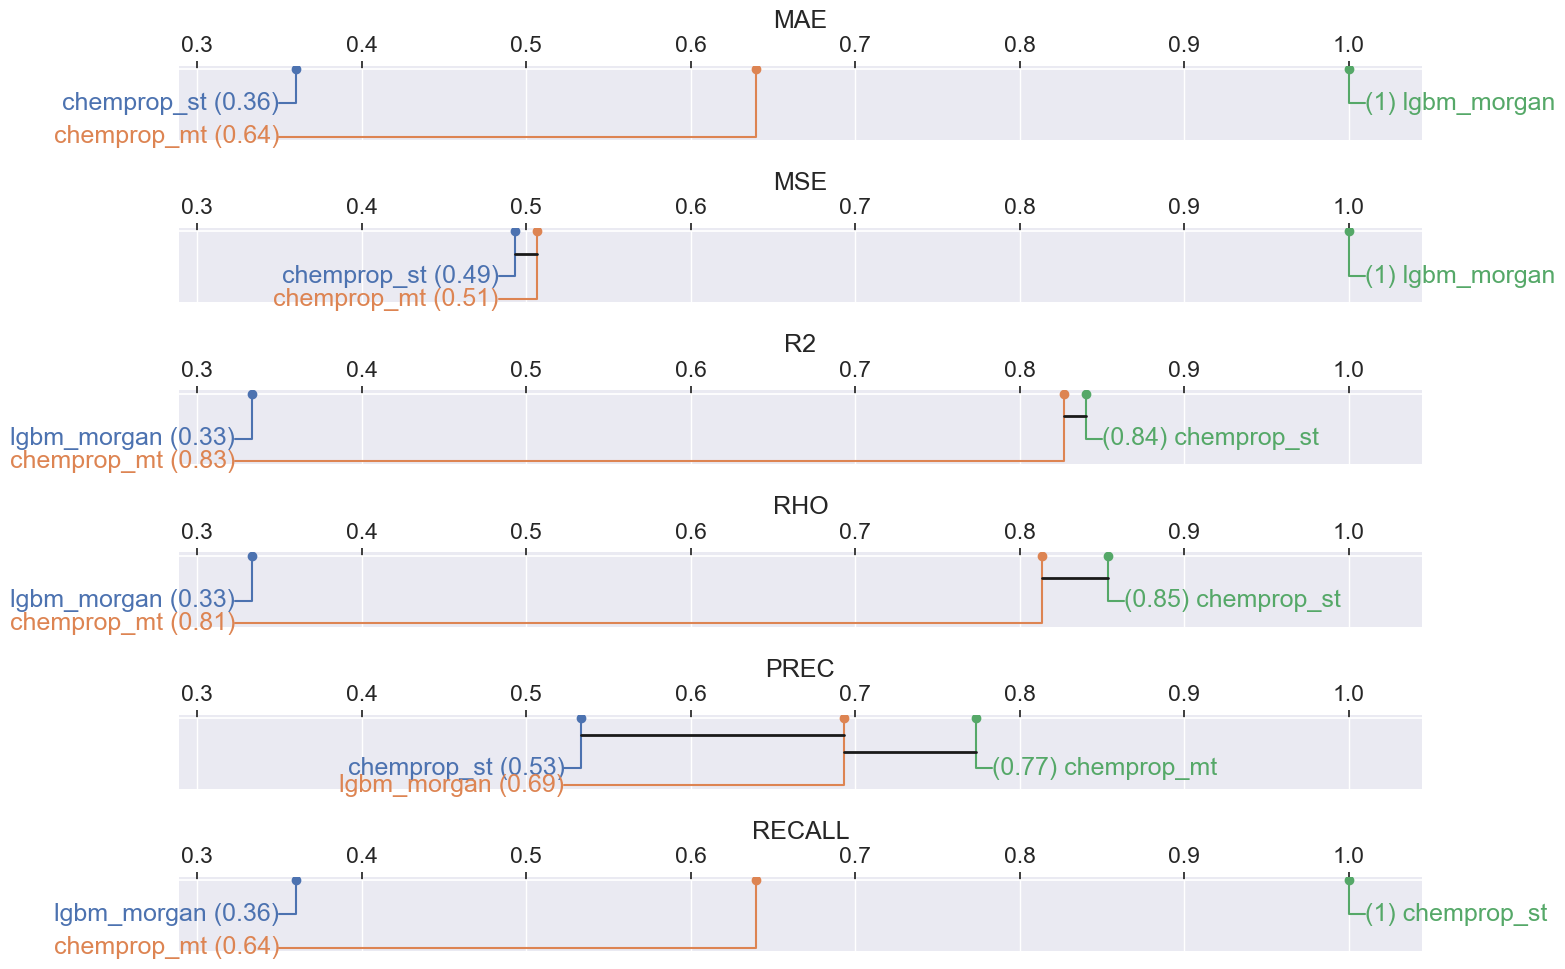

In [23]:
make_critical_difference_diagrams(df_scaffold_split, metric_ls)

### 6.2 Examine if performance differences are actually meaningful by looking at a scatterplot

There are statistically significant differences in MAE, MSE and R2 between lightGBM and chemprop, but is the effect size large enough to be meaningful? If we examine the precision and recall at the 100uM threshold, we see that precision stays constant (more or less) but recall is substantially lower for lightGBM. If you were to use these models as a compound filter at 100uM, chemprop_st would filter out less positives than lightgbm. The estimated improvement in recall of chemprop_st over lightGBM is .17, meaning chemprop_st would identify 17% more molecules with good solubility. This would likely have a real practical impact on drug discovery programs. 

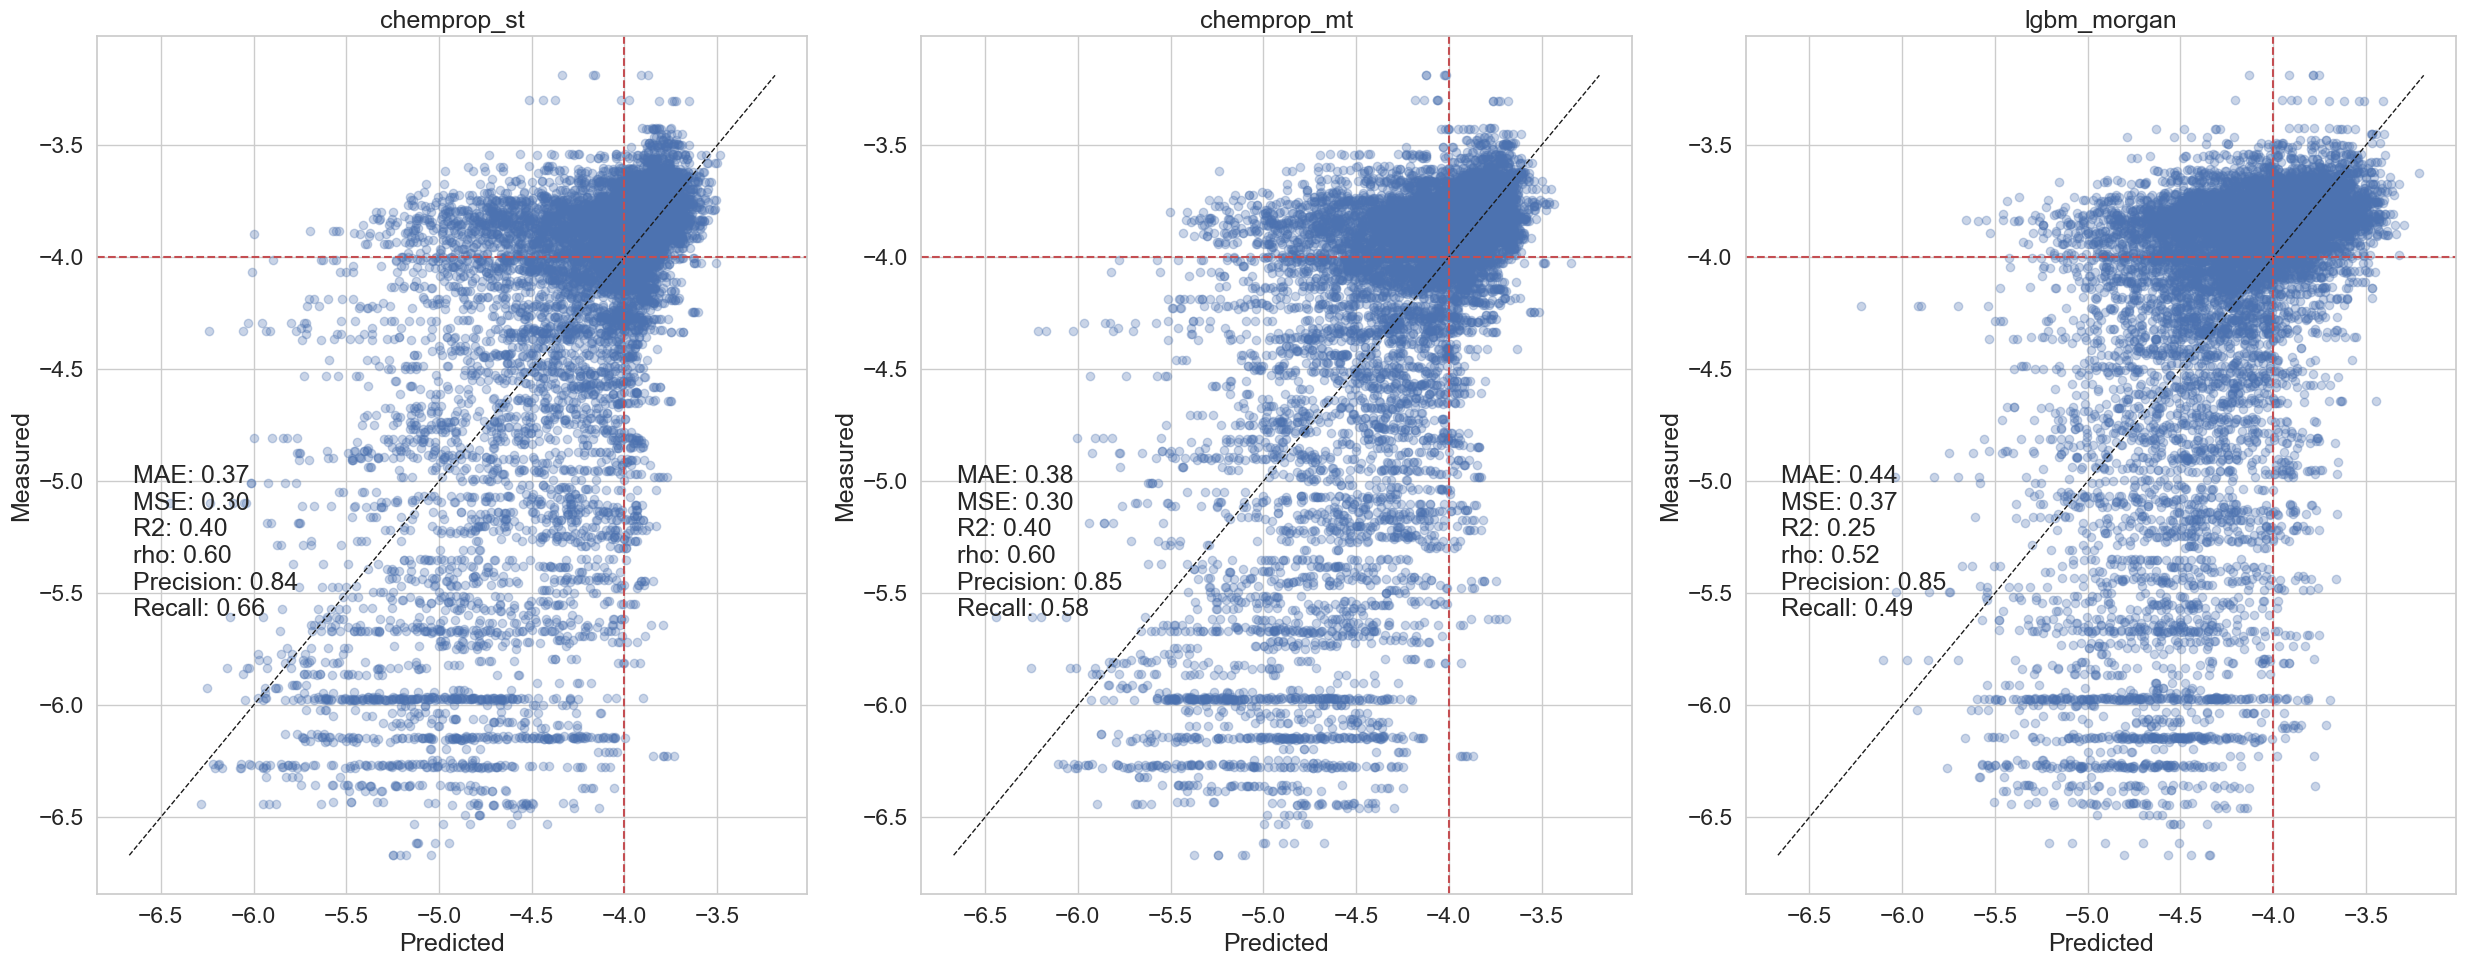

In [25]:
df_scaffold_in = df_input.query("split == 'scaffold'")
make_scatterplot(df_scaffold_in, "Sol", "Sol_pred", thresh=-4, cycle_col="cv_cycle", group_col="method") 